#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
hdr = db[{{ uid }}]

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Lazy Eiger Handler (later will goto databroker)

In [3]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [4]:
#%matplotlib notebook
%matplotlib inline

### Get the events from the uid

In [5]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [18]:
uid = 'c423e856'

In [19]:
hdr = db[uid]

In [20]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/10/30/915b6fb3-aaf6-44f0-a999_9092_master.h5


In [32]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 2500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [22]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 336.0,
 'count_time': 0.0049999999,
 'detector_distance': 4.8400002,
 'frame_time': 0.00501,
 'framerate': 199.60079982206346,
 'incident_wavelength': 1.3794414,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

<function __main__.view_image>

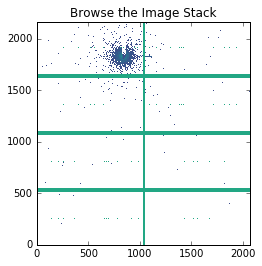

In [19]:
from ipywidgets import interact

def view_image(i):
    fig, ax = plt.subplots()
    ax.imshow(imgs[i], interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.001, vmax=1e10 ) )
    ax.set_title("Browse the Image Stack")
    #plt.show()
    
interact(view_image, i=(0, Nimg-1))

# a movie of images

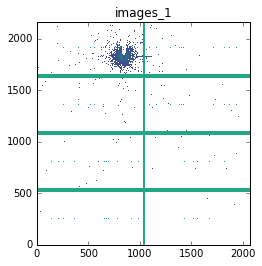

In [20]:
import time 
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        ax.imshow(imgs[i],  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.001, vmax=1e10 ) )
        ax.set_title("images_%s"%i)
        time.sleep( sleeps )
        plt.draw()
        
view_image( .2, 0, 2) 

### hey, let's see if any images are bad!

In [11]:
bin_img = 25
imgsum = [np.sum(img *imgs_mask) for img in imgs[::bin_img ]]

NameError: name 'imgs_mask' is not defined

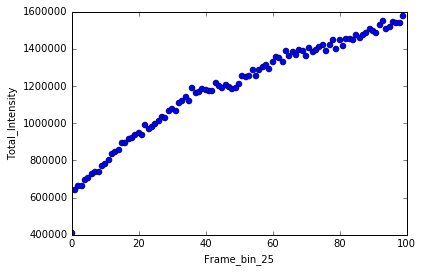

In [22]:
fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

### Get the Averaged Image Data

In [30]:
avg_img = np.average(imgs[::50], axis=0) * imgs_mask

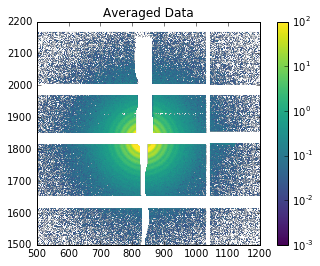

In [33]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img,  cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e2 ) )
ax.set_xlim([500,1200])
ax.set_ylim([1500,2200])
fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

# Get the masks

###  load a mask if exist 
### otherwise create a mask using Mask pipeline

In [35]:
mask = np.load(uid+"_mask.npy")

## Plot the mask

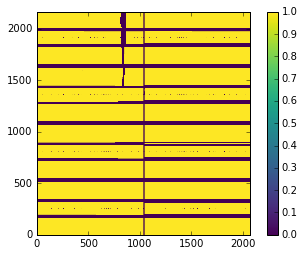

In [37]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Plot the averged image with the mask

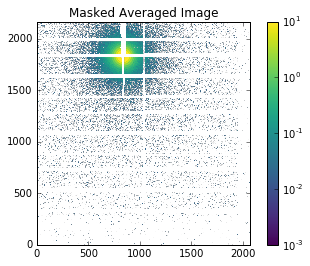

In [38]:
img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [39]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 336.0,
 'count_time': 0.0049999999,
 'detector_distance': 4.8400002,
 'frame_time': 0.00501,
 'framerate': 199.60079982206346,
 'incident_wavelength': 1.3794414,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [40]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

In [41]:
print (timeperframe)
print (exposuretime)

0.00501
0.005


## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [42]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi

import skxray.core.correlation as corr
import skxray.core.utils as utils

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Get the approximate center and see the statistic to make sure 

In [43]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(840.0, 336.0)

In [44]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1830, 840]

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [45]:
bin_centers, ring_averages= roi.circular_average(img_mask, 
        center, threshold=0, nx=2000, pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

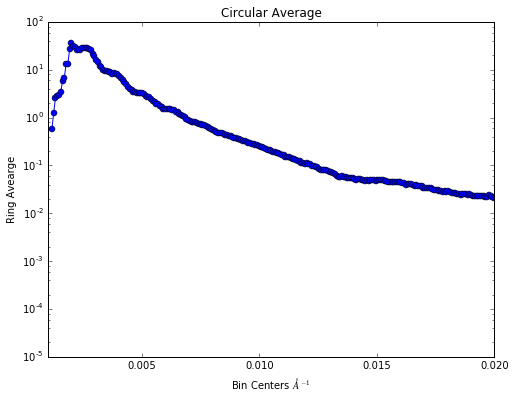

In [46]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0.001, 0.02)
plt.show()

## Create label array (Q rings)

##can we change the function of roi.ring_edges to give same values as make_qlist?

In [48]:
inner_radius = 44  # radius of the first ring
width = 2       # width of each ring
spacing =  (119 - 44)/9 - 2    # spacing between rings
num_rings = 10   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  44.        ,   46.        ],
       [  52.33333333,   54.33333333],
       [  60.66666667,   62.66666667],
       [  69.        ,   71.        ],
       [  77.33333333,   79.33333333],
       [  85.66666667,   87.66666667],
       [  94.        ,   96.        ],
       [ 102.33333333,  104.33333333],
       [ 110.66666667,  112.66666667],
       [ 119.        ,  121.        ]])

In [49]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.00300622,  0.00314286],
       [ 0.00357558,  0.00371222],
       [ 0.00414494,  0.00428158],
       [ 0.0047143 ,  0.00485094],
       [ 0.00528365,  0.0054203 ],
       [ 0.00585301,  0.00598966],
       [ 0.00642237,  0.00655902],
       [ 0.00699173,  0.00712838],
       [ 0.00756109,  0.00769773],
       [ 0.00813045,  0.00826709]])

In [56]:
q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00307454,  0.0036439 ,  0.00421326,  0.00478262,  0.00535198,
        0.00592134,  0.00649069,  0.00706005,  0.00762941,  0.00819877])

In [55]:
q_ring_center = np.array([(q_ring_val[i][0] + q_ring_val[i][1])/2 for 
                           i in range(num_rings)])
q_ring_center

array([ 0.00307454,  0.0036439 ,  0.00421326,  0.00478262,  0.00535198,
        0.00592134,  0.00649069,  0.00706005,  0.00762941,  0.00819877])

In [43]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

In [44]:
(q_ring_center/6.841437171805092e-05)[9]

119.839854621893

## Extract the labeled array

In [45]:
ring_mask

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [46]:
labels, indices = roi.extract_label_indices(ring_mask)

In [47]:
labels

array([ 10.,  10.,  10., ...,  10.,  10.,  10.])

In [48]:
indices

array([3540544, 3540545, 3540546, ..., 4033224, 4033225, 4033226])

## Number of pixels in each q ring

In [49]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([ 328,  450,  576,  649,  788,  871,  971, 1089, 1186, 1290])

# check center

## this function should be changed, 
### should check center before given ring_mask

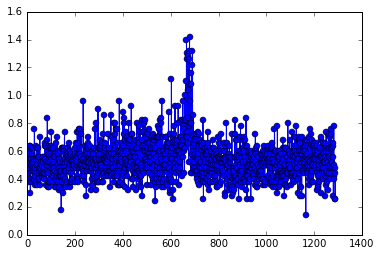

In [50]:
pixel = roi.roi_pixel_values( avg_img*mask, ring_mask, [10] )
fig,ax=plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )


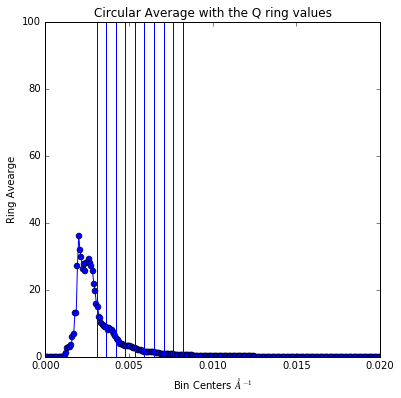

In [57]:
fig, axes = plt.subplots( figsize=(6, 6))
#axes.semilogy(q_val, ring_averages, '-o')
axes.plot(q_val, ring_averages, '-o')
axes.set_title('Circular Average with the Q ring values')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0, 0.02)
axes.set_ylim(0, 100)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

In [53]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

(1630, 2030)

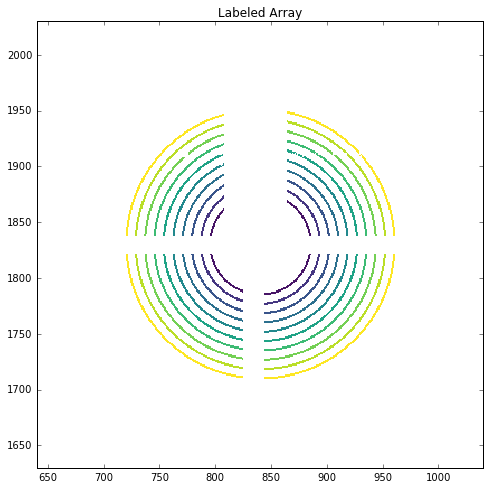

In [52]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 200 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])


## Plot Kymograph (Waterfall plot) for a vertical and hortizontal cuts


Note : Give coordinates of the upper-left corner and width and height of each
rectangle: e.g., [(x, y, w, h), (x, y, w, h)]


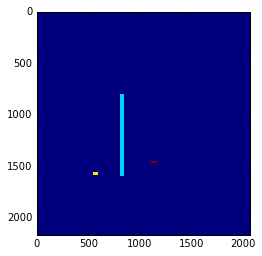

In [53]:
vert_rect = ((800, 803,800, 40), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)
plt.figure()
plt.imshow(V_K_label_array)
plt.show()

In [54]:
center

[1830, 840]

In [55]:
V_K_label_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##  Kymograph(waterfall plot) of the 3rd ring

In [56]:
masker = Masker(imgs, mask)

In [57]:
veri_kymo = roi.kymograph(masker[::50], V_K_label_array*mask, num = 1)

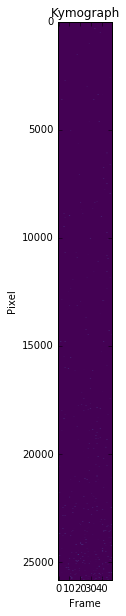

In [58]:

fig, ax = plt.subplots(figsize=(14,10))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(veri_kymo.T, cmap='viridis', vmax=10)
#fig.colorbar( im   )
ax.set_aspect(0.02)
plt.show()

In [59]:
mask_data = masker[::50]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

##  Mean intensities for each ring

In [60]:
mean_int_sets.shape

(50, 10)

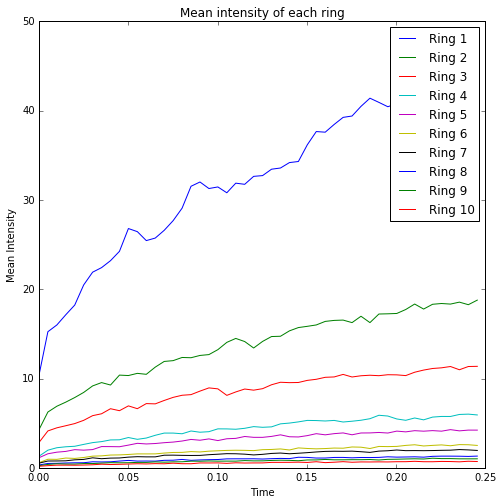

In [61]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [62]:
ring_mask = np.array( ring_mask, dtype=int)

In [63]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, ring_mask,    imgs)

### Plot the one time correlation functions

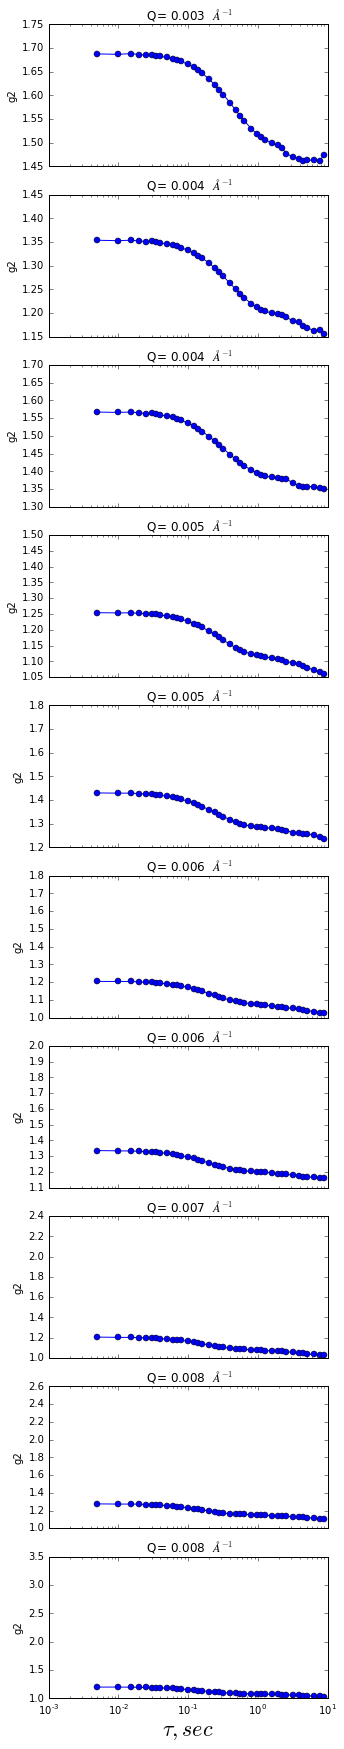

In [64]:
lags = lag_steps*timeperframe

fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 30))
axes[num_rings-1].set_xlabel(r"$\tau,sec$", fontsize=22)
for i in range(num_rings):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes[i].semilogx(lags, g2[:, i], '-o', markersize=6)
    #axes[i].set_ylim(bottom=1.10, top=1.15)
plt.show()

# Fit g2

In [65]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


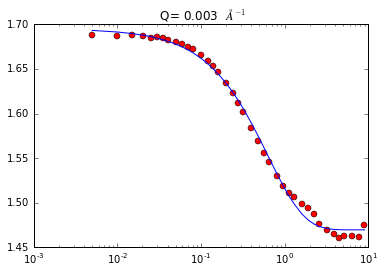

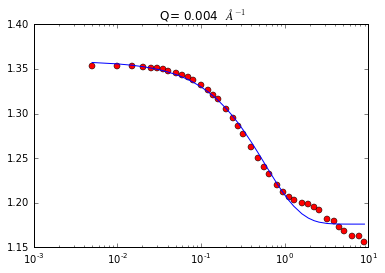

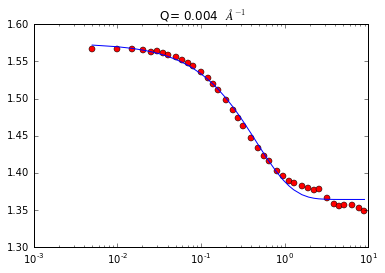

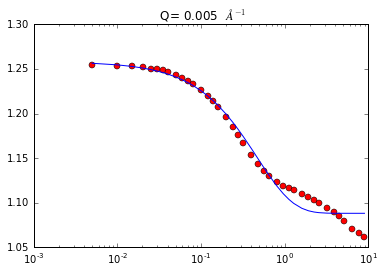

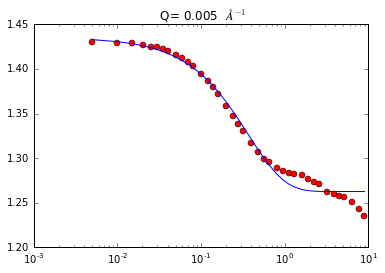

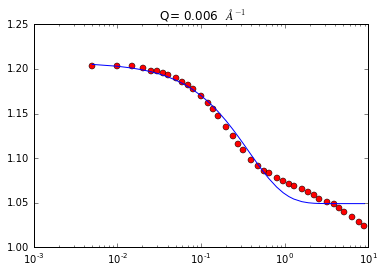

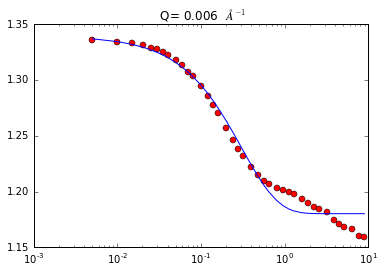

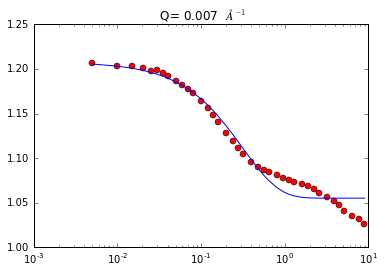

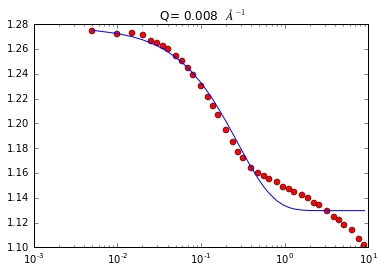

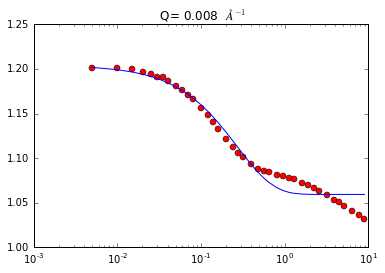

In [66]:
%matplotlib inline
rate = []
for i in range(num_rings):

    result1 = mod.fit(g2[1:,i], lags=lags[1:], beta=.1, relaxation_rate =.5,  baseline=1.0)

    rate.append(result1.best_values['relaxation_rate'])
    plt.figure()
    plt.semilogx(lags[1:], g2[1:, i], 'ro')
    plt.semilogx(lags[1:], result1.best_fit, '-b')
    #plt.ylim(1., 1.3)
    #axes[i].set_title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    
    plt.title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
plt.show()

In [67]:
result1.best_values

{'baseline': 1.0594209410128113,
 'beta': 0.14492830189481173,
 'relaxation_rate': 1.8344361090851411}

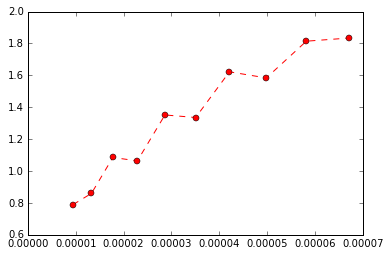

In [68]:
fig,ax=plt.subplots()
ax.plot( q_ring_center**2, rate, 'ro', ls='--')

In [71]:
D0 = np.polyfit(q_ring_center**2, rate, 1)
gmfit = np.poly1d(D0)
print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[0])

The fitted diffusion coefficient D0 is:  1.87E+04   A^2S-1


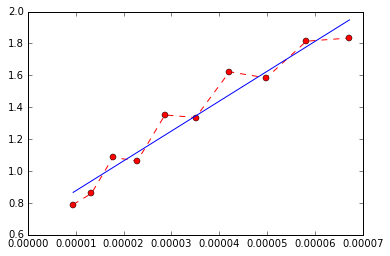

In [72]:
fig,ax=plt.subplots()
ax.plot( q_ring_center**2, rate, 'ro', ls='--')
ax.plot( q_ring_center**2,  gmfit( q_ring_center**2),  ls='-')
